# Presentation plots
***

**Author**: Chus Casado<br>
**Date**: 27-02-2023<br>

**Introduction**:<br>


**Questions**:<br>


**Tasks to do**:<br>

**Interesting links**<br>
[Pythonic way to perform statistics across multiple variables with Xarray](https://towardsdatascience.com/pythonic-way-to-perform-statistics-across-multiple-variables-with-xarray-d0221c78e34a)

In [1]:
import os
path_root = os.getcwd()
import glob
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
import time

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")

os.chdir('../py/')
from computations import *
from plots import *
os.chdir(path_root)

In [2]:
area = 500

In [3]:
# stn = 117
# start, end = datetime(2021, 1, 10), datetime(2021, 2, 28)

In [4]:
# stn = 118
# start, end = datetime(2021, 1, 10), datetime(2021, 2, 28)

In [5]:
# stn = 119
# start, end = datetime(2021, 1, 10), datetime(2021, 2, 28)
# start, end = datetime(2022, 10, 1), datetime(2022, 10, 31)

In [6]:
# stn = 2022
# start, end = datetime(2021, 5, 20), datetime(2021, 7, 31)

In [7]:
# stn = 5225
# start, end = datetime(2021, 7, 1), datetime(2021, 7, 31)

In [8]:
# stn = 356
# start, end = datetime(2021, 7, 1), datetime(2021, 8, 15)

In [9]:
# stn = 356
# start, end = datetime(2021, 7, 1), datetime(2021, 8, 15)

In [10]:
# stn = 337
# start, end = datetime(2021, 6, 1), datetime(2021, 7, 31)

In [11]:
# stn = 359
# start, end = datetime(2021, 6, 15), datetime(2021, 7, 31)

In [12]:
# stn = 931
# start, end = datetime(2021, 6, 15), datetime(2021, 7, 31)

In [13]:
# stn = 2562
# start, end = datetime(2022, 8, 1), datetime(2022, 8, 31)

In [14]:
# stn = 2562
# start, end = datetime(2021, 12, 10), datetime(2022, 1, 10)

In [15]:
# stn = 2766
# start, end = datetime(2021, 7, 1), datetime(2021, 7, 31)

In [16]:
stn = 2946
start, end = datetime(2022, 3, 20), datetime(2022, 4, 20)

In [17]:
stn = 2946
start, end = datetime(2021, 7, 1), datetime(2021, 7, 31)

In [18]:
stn = 2946
start, end = datetime(2021, 7, 1), datetime(2021, 7, 31)

**Nahe subcatchment**

In [19]:
stn = 114 # 110
start, end = datetime(2021, 7, 1), datetime(2021, 7, 31)

**Neckar subcatchment**

In [20]:
stn = 931 #33
start, end = datetime(2021, 6, 1), datetime(2021, 7, 31)

**Main**

In [21]:
stn = 119# 117# 118# 
start, end = datetime(2021, 1, 15), datetime(2021, 2, 15)

In [22]:
stn = 119# 117# 118# 
start, end = datetime(2022, 10, 1), datetime(2022, 11, 1)

In [23]:
stn = 39# 34# 2929
start, end = datetime(2021, 6, 20), datetime(2021, 7, 20)

### 1 Discharge forecast

#### List available data

In [24]:
path_forecast = 'E:/casadje/Documents/skill_assessment/data/CDS/forecast/'

# list files
fore_files = {model: [] for model in models}
for year in [2020, 2021, 2022]:
    for month in range(1, 13):    
        # list files
        for model in models:
            fore_files[model] += glob.glob(f'{path_forecast}{model}/{year}/{month:02d}/*.nc')

# count files and check if all are avaible
n_files = pd.Series(data=[len(fore_files[model]) for model in models], index=models)

# list of forecast from the beginning to the end of the data
for model in models:
    st, en = [datetime.strptime(fore_files[model][step][-13:-3], '%Y%m%d%H') for step in [0, -1]]
    start = max(st, start)
    end = min(en, end)
dates = pd.date_range(start, end, freq='12h')

# find missing files
if any(n_files != len(dates)):
    missing = {}
    for model in models:
        filedates = [datetime.strptime(file[-13:-3], '%Y%m%d%H') for file in fore_files[model]]    
        missing[model] = [date for date in dates if date not in filedates]
    print('mising files:', missing)

# trim files to the period where all models are available
for model in models:
    fore_files[model] = [file for file in fore_files[model] if start <= datetime.strptime(file[-13:-3], '%Y%m%d%H') <= end]
    print('{0}:\t{1} files'.format(model, len(fore_files[model])))

mising files: {'COS': [], 'DWD': [], 'EUD': [], 'EUE': []}
COS:	61 files
DWD:	61 files
EUD:	61 files
EUE:	61 files


## 2 Analysis

### 2.1 Stations 

In [25]:
stations = pd.read_parquet(f'../results/reporting_points/reporting_points_over_{area}km2.parquet')

print('no. stations:\t\t\t{0}'.format(stations.shape[0]))

stations = pd.DataFrame(stations.loc[stn]).transpose()

thresholds = stations[['rl1.5', 'rl2', 'rl5', 'rl20']].squeeze()

title = '{0} - {1} ({2})'.format(stn, *stations.loc[stn, ['name', 'subcatchment']])

no. stations:			2371


### Reanalysis

In [26]:
# load probability of exceeding the discharge threshold in the REANALYSIS data
Qobs = pd.read_parquet(f'../data/discharge/reanalysis/EFAS_discharge_reanalysis.parquet')
Qobs.columns = Qobs.columns.astype(int)
Qobs = Qobs[stn]

In [27]:
# observed events
obs = (Qobs > thresholds.rl5).astype(int).loc[start + timedelta(days=10):end]
print('no. observed events:\t{0}'.format((np.diff(obs) == 1).sum()))
obs = xr.DataArray(obs, coords={'datetime': obs.index})

no. observed events:	1


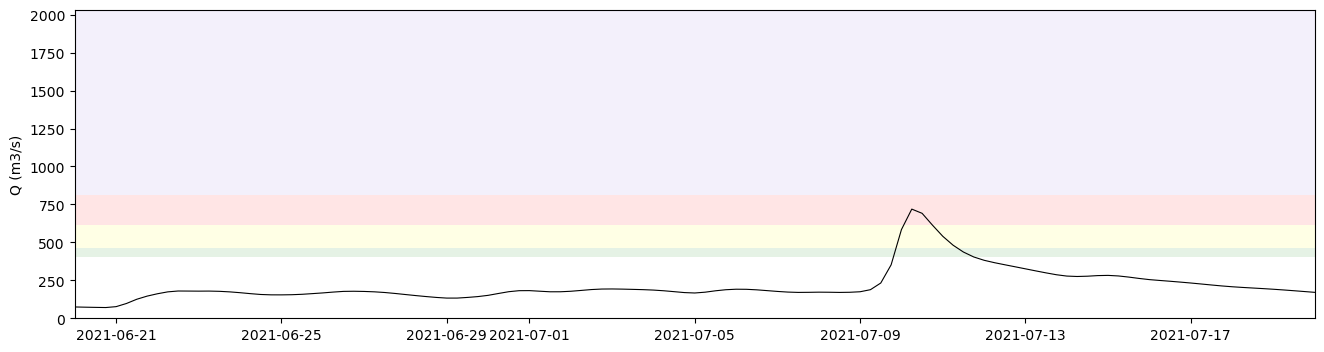

In [28]:
ymax = thresholds.rl20 * 2.5 #60

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(Qobs.index, Qobs, c='k', lw=.8, zorder=5)
if thresholds is not None:
    ax.fill_between(pd.date_range(start, end), thresholds['rl1.5'], thresholds['rl2'], color='green', edgecolor=None, alpha=.1, zorder=0, label='1.5-year')
    ax.fill_between(pd.date_range(start, end), thresholds['rl2'], thresholds['rl5'], color='yellow', edgecolor=None, alpha=.1, zorder=0, label='2-year')
    ax.fill_between(pd.date_range(start, end), thresholds['rl5'], thresholds['rl20'], color='red', edgecolor=None, alpha=.1, zorder=0, label='5-year')
    ax.fill_between(pd.date_range(start, end), thresholds['rl20'], ymax, color='mediumpurple', edgecolor=None, alpha=.1, zorder=0, label='20-year')
ax.set(xlim=(start, end), ylim=(0, ymax), ylabel='Q (m3/s)');

### 2.2 Reforecast data: exceedance probability

This section will iteratively (station by station) load all the available forecast and compute the probability of exceeding the discharge threshold for each of the meteorological forcings. The result will be a NetCDF file for each station that contains the exceedance probability. These files will be later used in the skill assessment.

COS	E:/casadje/Documents/skill_assessment/data/CDS/forecast/COS/2021/07\COS2021072000.nc
DWD	E:/casadje/Documents/skill_assessment/data/CDS/forecast/DWD/2021/07\DWD2021072000.nc
EUD	E:/casadje/Documents/skill_assessment/data/CDS/forecast/EUD/2021/07\EUD2021072000.nc
EUE	E:/casadje/Documents/skill_assessment/data/CDS/forecast/EUE/2021/07\EUE2021072000.nc


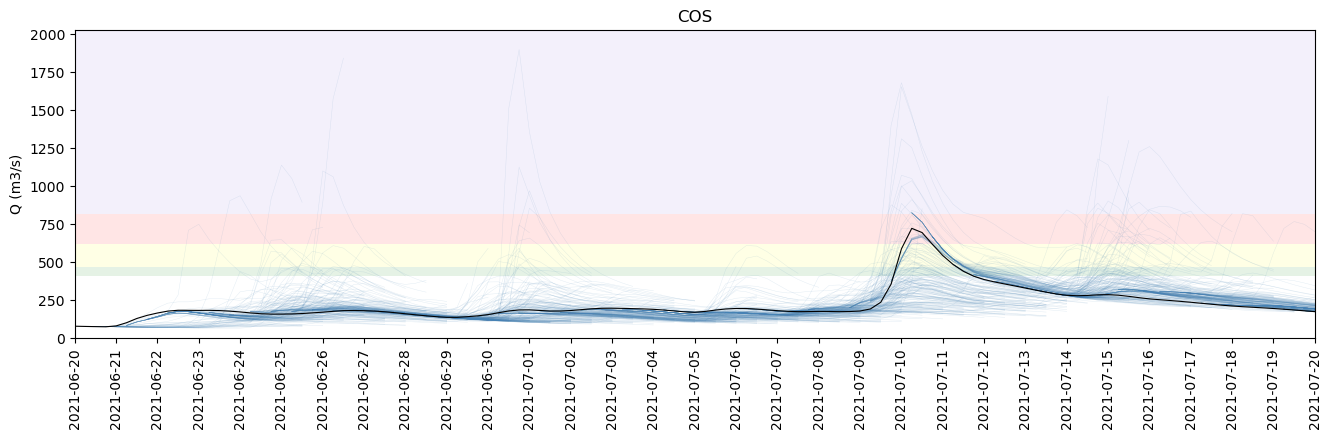

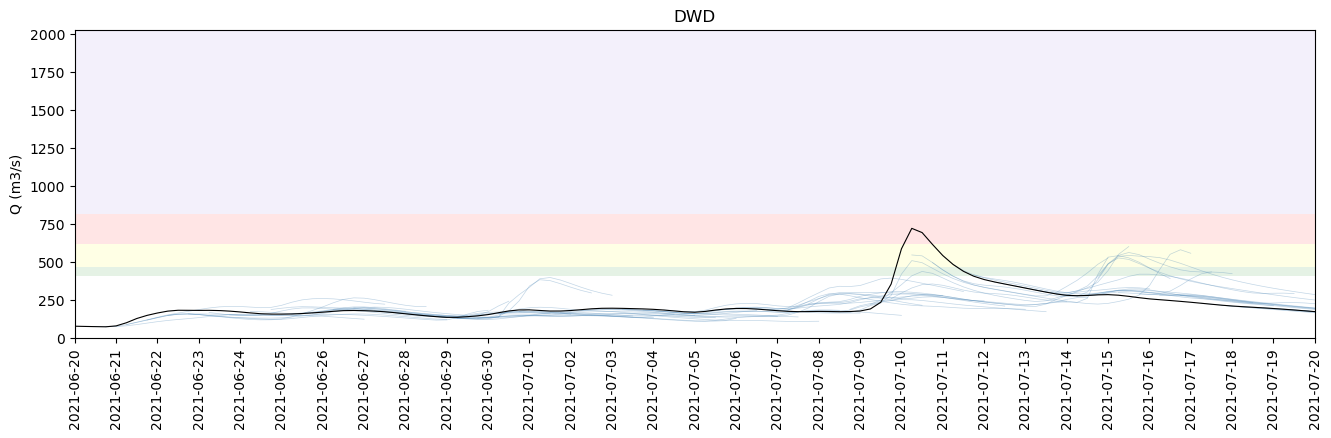

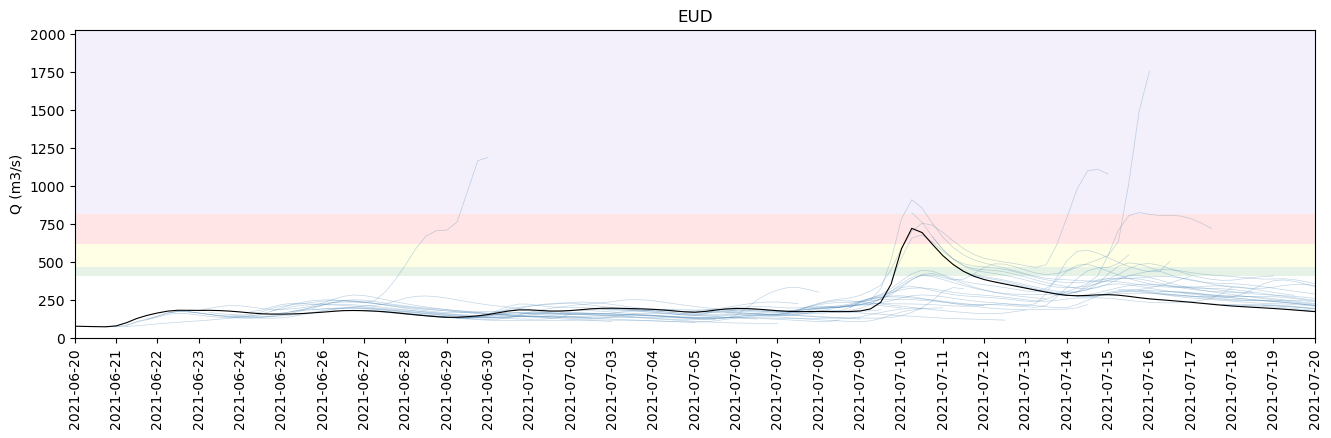

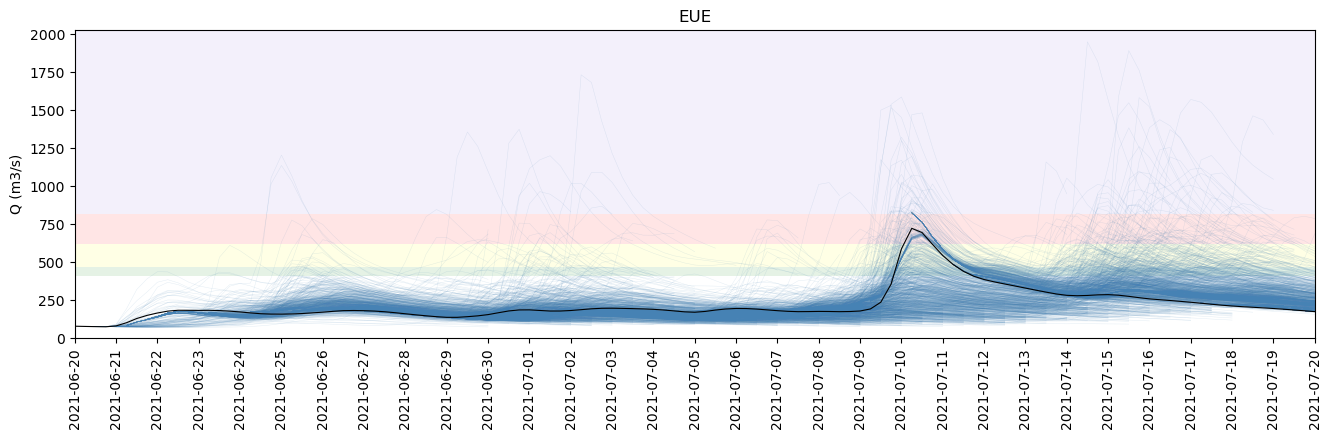

In [29]:
ymax = thresholds.rl20 * 2.5

for model in models:

    fig, ax = plt.subplots(figsize=(16, 4))

    for file in fore_files[model]:

        print(f'{model}\t{file}', end='\r')

        # open dataaray with dicharge data
        dis = xr.open_dataarray(file).isel(time=slice(1, None))
        dis['time'] = dis.time - np.timedelta64(6, 'h')
        # limit the forecast to its maximum leadtime
        if len(dis.time) > models[model]['leadtimes']:
            dis = dis.isel(time=slice(None, models[model]['leadtimes']))

        dis_stn = dis.sel(stations=str(stn))

        if 'member' in dis_stn.dims:
            for member in dis_stn.member.data:
                ax.plot(dis_stn.time, dis_stn.sel(member=member), c='steelblue', lw=.33, alpha=.15)
        else:
            ax.plot(dis_stn.time, dis_stn, c='steelblue', lw=.5, alpha=.33)

    ax.plot(Qobs.index, Qobs, c='k', lw=.8, zorder=5)

    ax.set(xlim=(start + timedelta(days=10), end), ylim=(0, ymax), ylabel='Q (m3/s)')
    xticks = pd.date_range(start, end, freq='d').date
    ax.set_xticks(xticks, labels=xticks, rotation=90)
    # ax.grid(True)

    if thresholds is not None:
        ax.fill_between(pd.date_range(start, end), thresholds['rl1.5'], thresholds['rl2'], color='green', edgecolor=None, alpha=.1, zorder=0, label='1.5-year')
        ax.fill_between(pd.date_range(start, end), thresholds['rl2'], thresholds['rl5'], color='yellow', edgecolor=None, alpha=.1, zorder=0, label='2-year')
        ax.fill_between(pd.date_range(start, end), thresholds['rl5'], thresholds['rl20'], color='red', edgecolor=None, alpha=.1, zorder=0, label='5-year')
        ax.fill_between(pd.date_range(start, end), thresholds['rl20'], ymax, color='mediumpurple', edgecolor=None, alpha=.1, zorder=0, label='20-year')

    ax.set_title(model);

    plt.savefig(f'../results/skill/explanation/{stn:>04}_{start:%Y%m%d}_{end:%Y%m%d}_{model}.jpg', dpi=300, bbox_inches='tight')
    
    print()

#### Exceendance probability

In [30]:
# criteria
probability = .25
min_leadtime = 60
persistence = (2, 2)

In [31]:
probability = 0.375
persistence = (1, 1)

**Raw data**

In [32]:
exceedance = xr.open_dataarray(f'E:/casadje/GitHub/EFAS_skill/data/exceedance/forecast/{stn:>04d}.nc')
exceedance = exceedance.sel(forecast=slice(start, end))
exceedance = reshape_DataArray(exceedance)
exceedance = exceedance.sel(datetime=slice(start + timedelta(days=10), end))

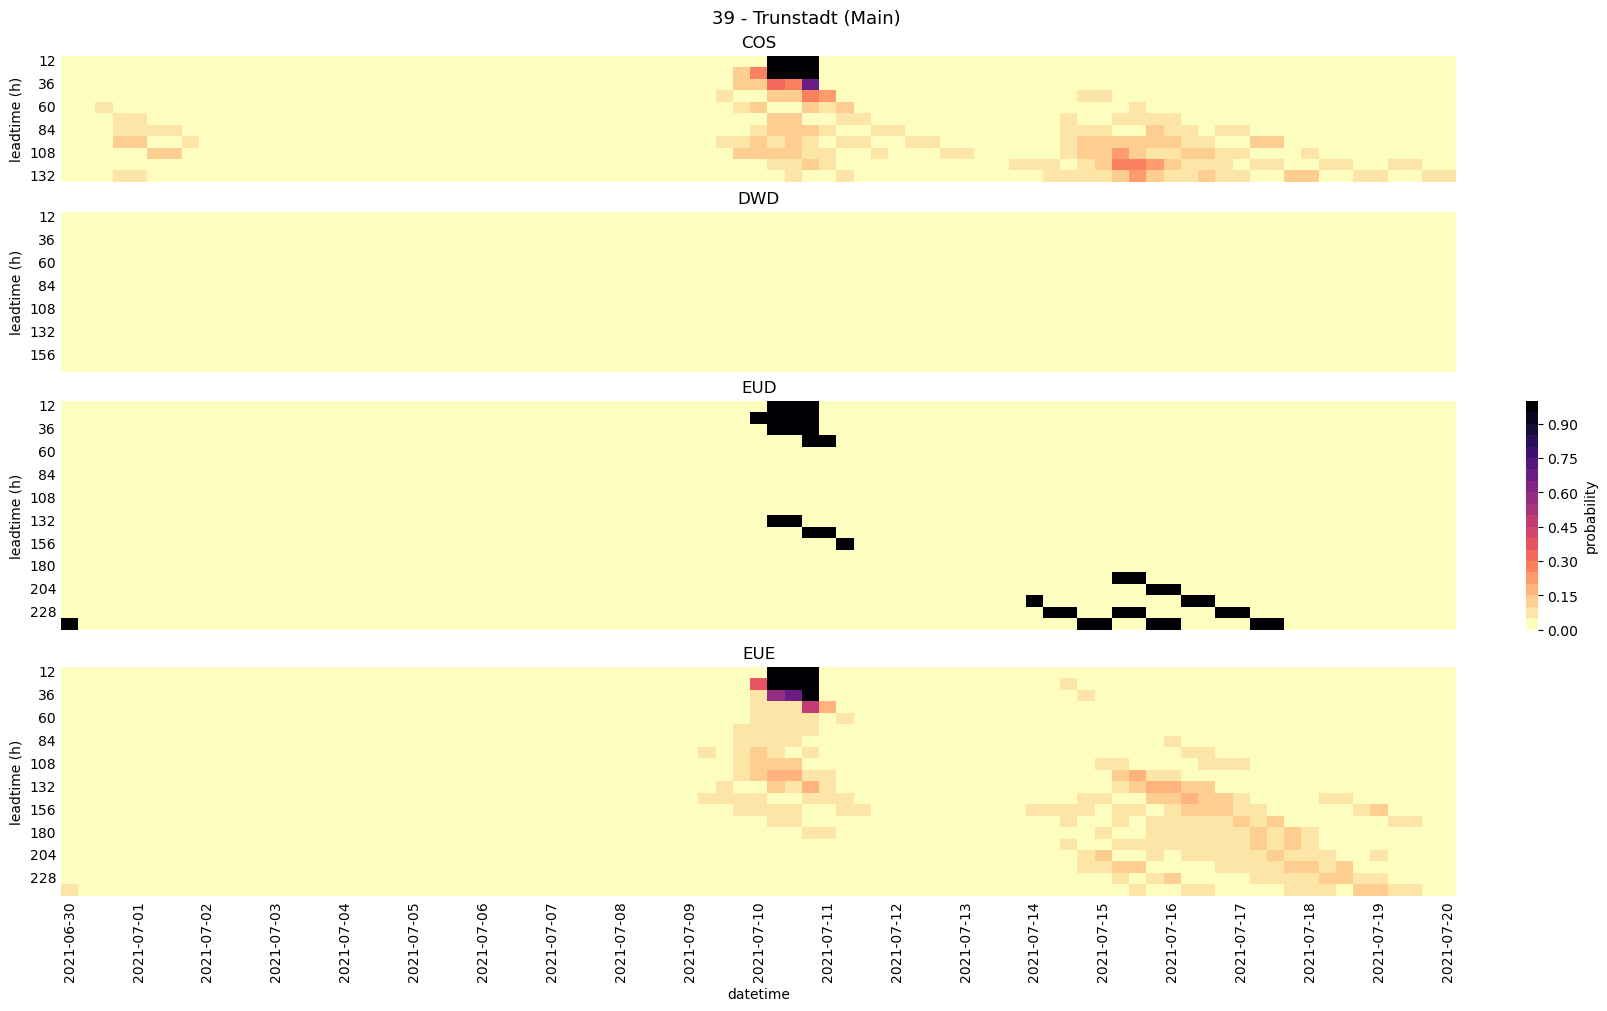

In [33]:
cmap_p, norm_p = create_cmap('magma_r', np.arange(0, 1.01, .05))

fig = plt.figure(figsize=(16, 10), constrained_layout=True)
height_ratios = [int(dct['leadtimes'] / 2) for label, dct in models.items()]
gs = fig.add_gridspec(nrows=len(height_ratios), height_ratios=height_ratios)

for i, (label, dct) in enumerate(models.items()):
    ax = fig.add_subplot(gs[i])
    if i + 1 < len(height_ratios):
        xticklabels, xlabel = [], None
    else:
        xticklabels, xlabel = exceedance.datetime.data, 'datetime'
    ylabel = 'leadtime (h)'
    if i == 2:
        cbar = True
    else:
        cbar = False
    plot_DataArray(exceedance.sel(model=label).isel(leadtime=slice(0, int(models[label]['leadtimes'] / 2))),
                   xtick_step=4, ytick_step=2, cbar=cbar, cbar_kws={'label': 'probability'}, title=label, xticklabels=xticklabels, xlabel=xlabel,
                   ylabel=ylabel, ax=ax, cmap=cmap_p, norm=norm_p)
    
fig.suptitle(title, fontsize=13);

plt.savefig(f'../results/skill/explanation/{stn:>04}_{start:%Y%m%d}_{end:%Y%m%d}_exceedance_probability.jpg', dpi=300, bbox_inches='tight')

**1 deterministic & 1 probabilistic**

In [34]:
def plot_prediction(da, obs, probability, persistence=(1, 1), min_leadtime='all', center=True, w=5, save=None, **kwargs):
    """
    """
    
    cmap = kwargs.get('cmap', 'magma_r')
    norm = kwargs.get('norm', None)
    
    fig = plt.figure(figsize=kwargs.get('figsize', (16, 6.6)), constrained_layout=True)
    height_ratios = [len(da.leadtime)] * 2 + [1] * 3
    gs = fig.add_gridspec(nrows=len(height_ratios), height_ratios=height_ratios)
    
    # total probability
    plot_DataArray(da, ytick_step=2, cbar=False, cbar_kws={'label': 'probability'}, title='total probability',
                   xticklabels=[], xlabel=None, ylabel='leadtime (h)', cmap=cmap, norm=norm, ax=fig.add_subplot(gs[0]))
    
    # exceedance over probability threshold
    plot_DataArray(da > probability, ytick_step=2, cbar=True, cbar_kws={'label': 'probability'}, title='exceedance', xlabel=None,
                   xticklabels=[], ylabel='leadtime (h)', cmap=cmap, norm=norm, ax=fig.add_subplot(gs[1]))
    
    # predicted events
    pred = compute_events(da, probability=probability, persistence=persistence, min_leadtime=min_leadtime)
    plot_prediction.pred = pred
    plot_DataArray(pred, title='predicted', xticklabels=[], cmap=cmap, norm=norm, cbar=False, ax=fig.add_subplot(gs[2]))
    
    # buffered, predicted events
    buff = buffer_events(pred, center=center, w=w)
    plot_prediction.buff = buff
    plot_DataArray(buff, title='buffered', xticklabels=[], cmap=cmap, norm=norm, cbar=False, ax=fig.add_subplot(gs[3]))

    # observed events
    plot_DataArray(obs, xlabel='datetime', xtick_step=4, title='observed', cmap=cmap, norm=norm, cbar=False, ax=fig.add_subplot(gs[4]))
    
    if 'title' in kwargs:
        fig.suptitle(kwargs['title'], fontsize=13);
    
    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches='tight')

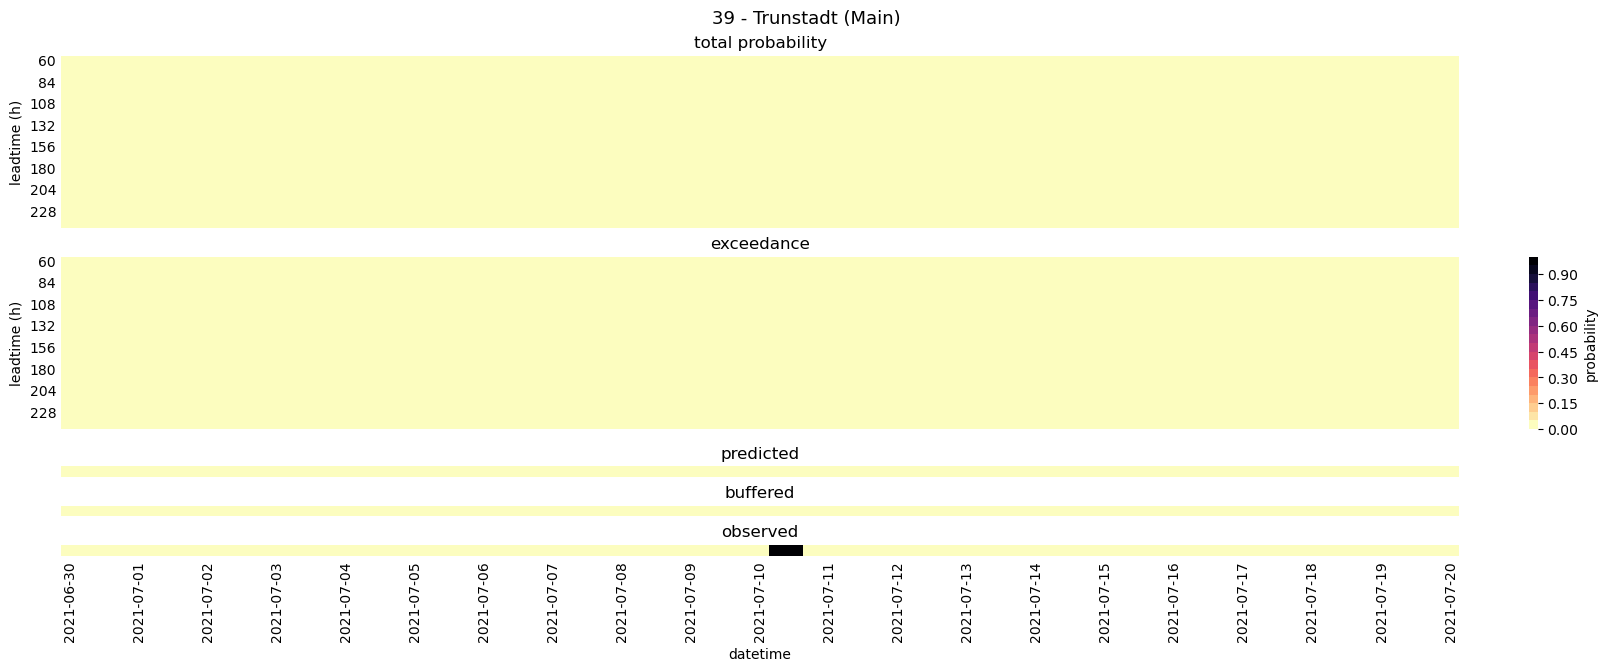

In [35]:
# exceedance according to current criteria
deterministic = (exceedance.sel(model=['EUD', 'DWD']) >= probability).any('model')
probabilistic = (exceedance.sel(model=['EUE', 'COS']) >= probability).any('model')
current = (deterministic & probabilistic).sel(leadtime=slice(min_leadtime, None))

plot_prediction(current, obs, probability, persistence, min_leadtime,
                cmap=cmap_p, norm=norm_p, title=title,
                save=f'../results/skill/explanation/{stn:>04}_{start:%Y%m%d}_{end:%Y%m%d}_current.jpg')

**Model mean**

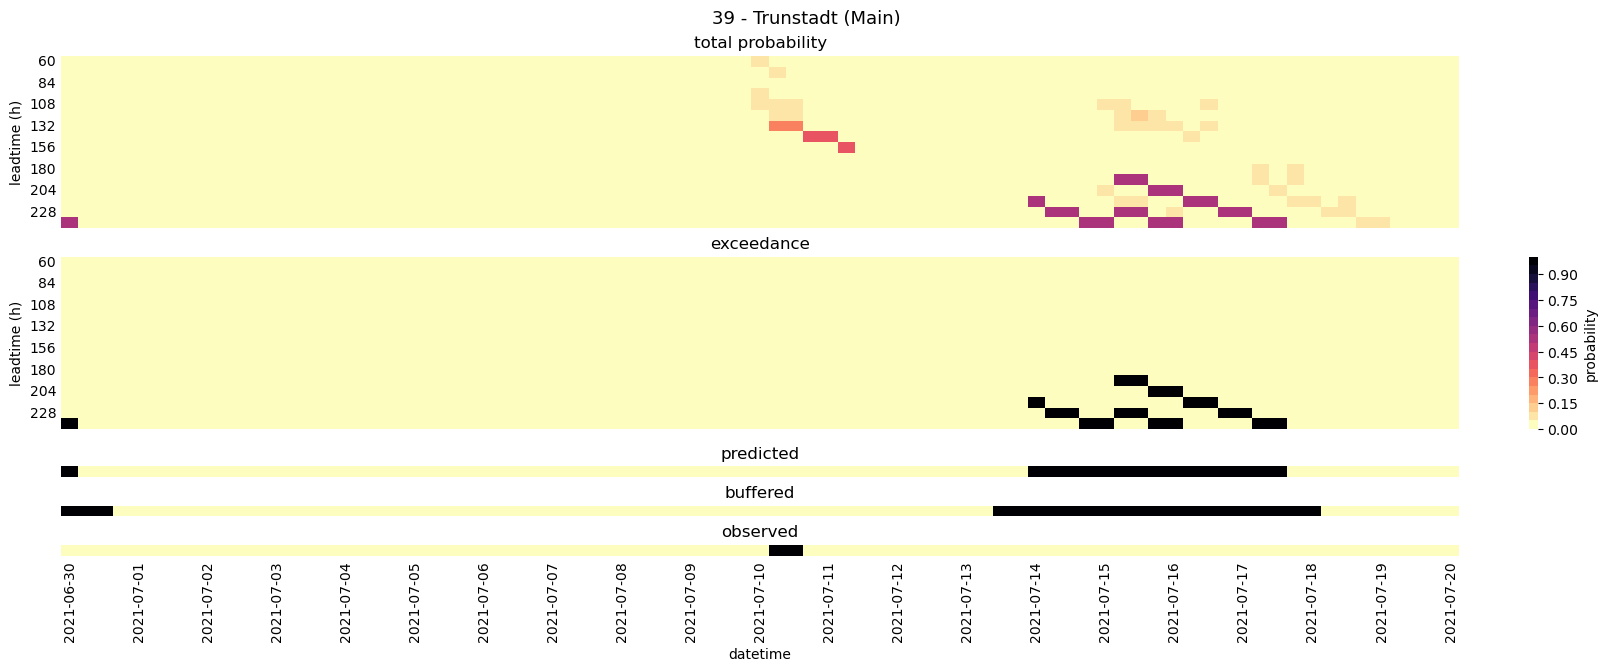

In [36]:
# exceedance according to mean over models
model_mean = exceedance.mean('model', skipna=True).sel(leadtime=slice(min_leadtime, None))

plot_prediction(model_mean, obs, probability, persistence, min_leadtime,
                cmap=cmap_p, norm=norm_p, title=title,
                save=f'../results/skill/explanation/{stn:>04}_{start:%Y%m%d}_{end:%Y%m%d}_model_mean.jpg')

**Weighted by no. members**

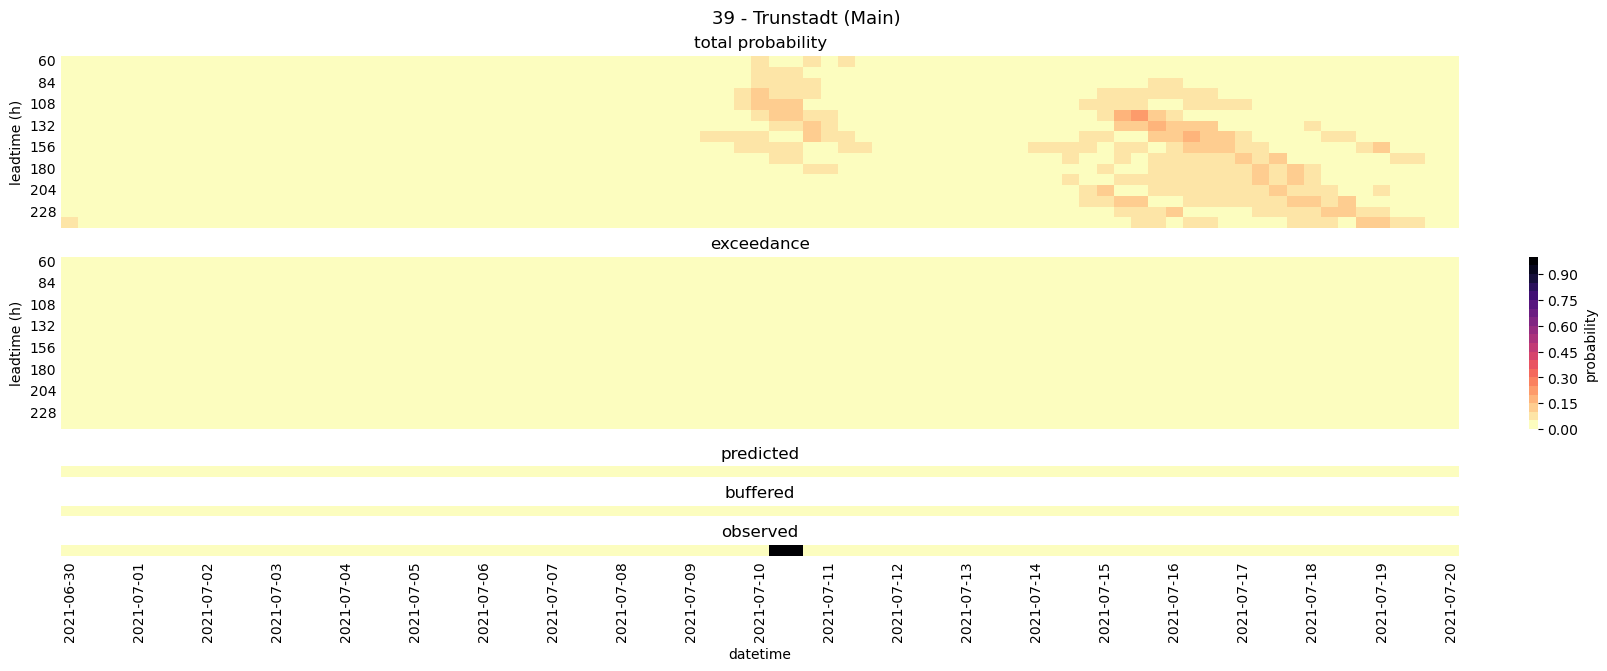

In [37]:
# by the number of members
path_in = '../data/'
weights_member = xr.open_dataarray(f'{path_in}weights_member.nc')

# exceedance according to the mean over models weighted by the number of members
member_weighted = exceedance.weighted(weights_member).mean('model', skipna=True).sel(leadtime=slice(min_leadtime, None))

plot_prediction(member_weighted, obs, probability, persistence, min_leadtime,
                cmap=cmap_p, norm=norm_p, title=title,
                save=f'../results/skill/explanation/{stn:>04}_{start:%Y%m%d}_{end:%Y%m%d}_member_weighted.jpg')

**Weighted by performance**

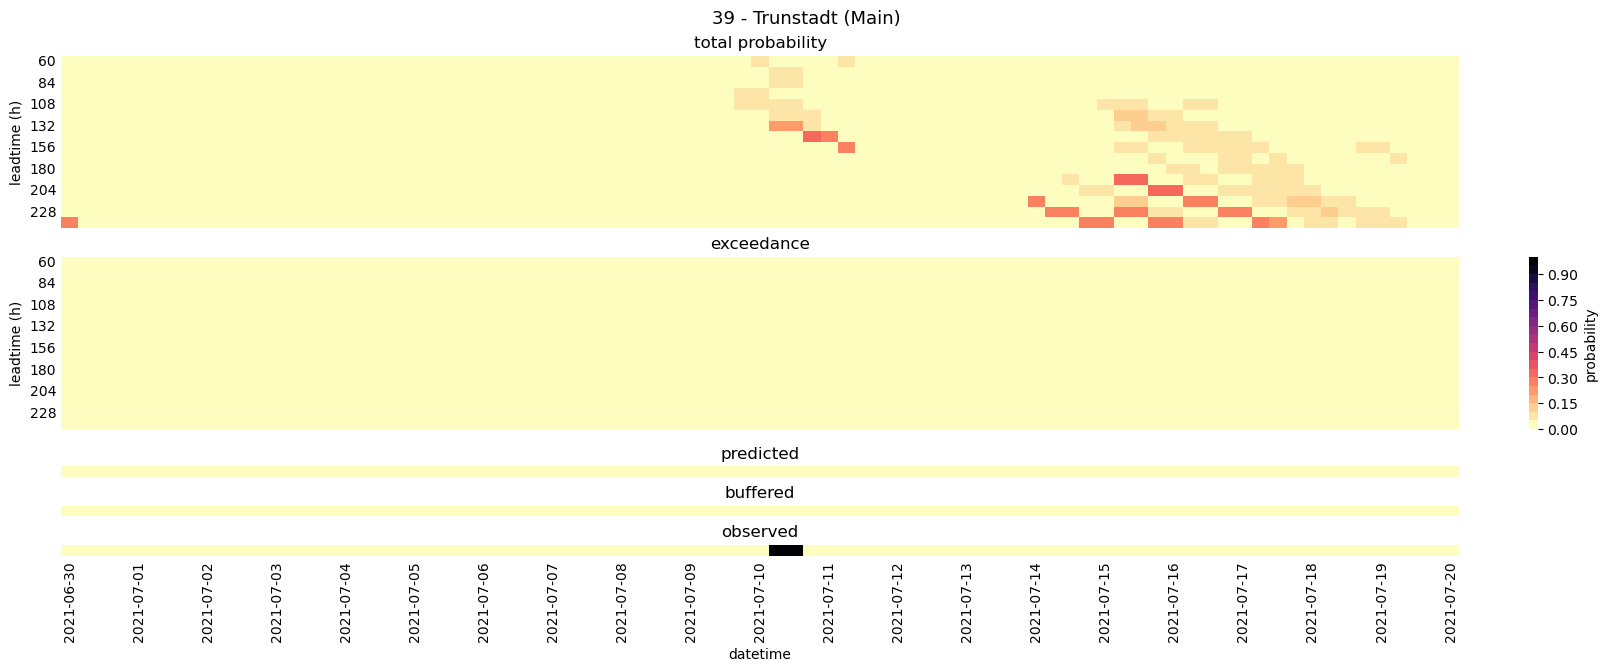

In [38]:
# by the Brier score
weights_brier = xr.open_dataarray(f'{path_in}weights_brier.nc', engine='netcdf4')

# exceedance according to the mean over models weighted by the number of members
brier_weighted = exceedance.weighted(weights_brier.fillna(0)).mean('model', skipna=True).sel(leadtime=slice(min_leadtime, None))

plot_prediction(brier_weighted, obs, probability, persistence, min_leadtime,
                cmap=cmap_p, norm=norm_p, title=title,
                save=f'../results/skill/explanation/{stn:>04}_{start:%Y%m%d}_{end:%Y%m%d}_brier_weighted.jpg')

In [ ]:
exc_o_thr = exceedance >= .3

In [ ]:
cmap_eot, norm_eot = create_cmap('magma_r', np.arange(0, 1.01, .5))

In [ ]:
fig = plt.figure(figsize=(16, 10), constrained_layout=True)
height_ratios = [int(dct['leadtimes'] / 2) for label, dct in models.items()]
gs = fig.add_gridspec(nrows=len(height_ratios), height_ratios=height_ratios)

for i, (label, dct) in enumerate(models.items()):
    ax = fig.add_subplot(gs[i])
    if i + 1 < len(height_ratios):
        xticklabels, xlabel = [], None
    else:
        xticklabels, xlabel = exceedance.datetime.data, 'datetime'
    ylabel = 'leadtime (h)'
    if i == 2:
        cbar = True
    else:
        cbar = False
    plot_DataArray(exc_o_thr.sel(model=label).isel(leadtime=slice(0, int(models[label]['leadtimes'] / 2))),
                   xtick_step=4, ytick_step=2, cbar=cbar, cbar_kws={'label': 'exceedance over threshold'}, title=label, xticklabels=xticklabels, xlabel=xlabel,
                   ylabel=ylabel, ax=ax, cmap=cmap_eot, norm=norm_eot)
    
fig.suptitle('{0} - {1} ({2})'.format(stn, *stations.loc[stn, ['name', 'catchment']]), fontsize=13);

In [ ]:
# exceedance according to current criteria
deterministic = (exceedance.sel(model=['EUD', 'DWD']) >= .3).any('model')
probabilistic = (exceedance.sel(model=['EUE', 'COS']) >= .3).any('model')
current = deterministic & probabilistic

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=(16, 10), sharex=True, sharey=True, constrained_layout=True)

plot_DataArray(deterministic, ax=ax[0], cmap=cmap_eot, norm=norm_eot, cbar=False, title='deterministic')
plot_DataArray(probabilistic, ax=ax[1], cmap=cmap_eot, norm=norm_eot, cbar=True, cbar_kws={'shrink': .25, 'label': 'exceedance over threshold'}, title='probabilistic')
plot_DataArray(current, ax=ax[2], cmap=cmap_eot, norm=norm_eot, cbar=False, title='deterministic & probabilistic',
               xtick_step=4, ytick_step=2)

fig.suptitle('{0} - {1} ({2})'.format(stn, *stations.loc[stn, ['name', 'catchment']]), fontsize=13);

In [ ]:
current

In [ ]:
min_leadtime = 60
persistence = (3, 3)

***

In [ ]:
def compute_events(da, probability=None, persistence=(1, 1), by_leadtime=False, min_leadtime=None):
    """It defines predicted events out of a DataArray of exceendances over a probability threshold. 
    The persistence criterion defines the number of forecast that must predict an exceedance in order to be considered an event.
    
    Inputs:
    -------
    da:           xr.DataArray. A matrix of exceedances over probability threshold. It must have a dimension called 'leadtime', over which the function will compute persistence
    persistence:  tuple (a, b). Two values that define the number of positive forecasts (a) out of a series of consecutive forecast (b) needed to consider the prediction as an event
    resample:     string. 
    
    Output:
    -------
    As objetcs:
    events:       xr.DataArray. A matrix of predicted events. The dimension 'leadtime' in the input DataArray (length 20 in the usual case) is collapsed to a single value.
    As method:
    exceedance:   xr.DataArray. Matrix of cells that exceed the 'probability' threshold
    """
    
    # invert 'leadtime' order from longer to shorter lead times
    da = da.sel(leadtime=slice(min_leadtime, None)).isel(leadtime=slice(None, None, -1))

    # compute exceedance over the probability threshold
    if probability is None:
        exceedance = da
    else:
        exceedance = (da >= probability).astype(int)
    #compute_events.exceedance = exceedance.isel(leadtime=slice(None, None, -1))

    # compute persistence (rolling sum over a window exceeds a number of forecast positives)
    events = (exceedance.rolling({'leadtime': persistence[1]}, center=False, min_periods=1).sum() >= persistence[0]) & exceedance
    events = events.isel(leadtime=slice(None, None, -1))
    
    if by_leadtime:
        events_agg = events.copy()
        for lt in events_agg.leadtime.data:
            events_agg.loc[dict(leadtime=lt)] = events.sel(leadtime=slice(lt, None)).any('leadtime').astype(int)
        return events_agg

    # if resample is not None:
    #     # convert 'leadtime' from integer hours to timedelta
    #     events['leadtime'] = pd.to_timedelta(events.leadtime, 'h')
    #     # resample
    #     events = events.resample({'leadtime': resample}).any().astype(int)
    #     # reconvert 'leadtime' back to intege hours
    #     events['leadtime'] = (events.leadtime / np.timedelta64(1, 'h')).astype(int)
    #     return events.sel(leadtime=slice(min_leadtime, None))
    else:
        # check if there's any predicted event
        return events.any('leadtime').astype(int)
        

In [ ]:
pred_events = compute_events(current, persistence=(3, 3), min_leadtime=60, by_leadtime=False)

In [ ]:
path_reanalysis = '../data/exceedance/reanalysis/'

# load probability of exceeding the discharge threshold in the REANALYSIS data
rean_exc = pd.read_parquet(f'{path_reanalysis}/exceedance_rl5.parquet')
rean_exc.columns = rean_exc.columns.astype(int)
rean_exc = rean_exc.loc[start:end, stations.index.tolist()]

# compute onsets of the flood events
rean_onsets = rean_exc.astype(int).diff(axis=0) == 1
rean_onsets.iloc[0,:] = rean_exc.iloc[0,:]

# create a DataArray with the number of observed events per station
n_events_obs = xr.DataArray(rean_onsets.sum(), dims=['id'], coords={'id': rean_onsets.columns.tolist()})
print('no. events:\t\t\t{0}'.format(n_events_obs.sum().data))

# select stations with events
mask_stn = (n_events_obs > 0).to_pandas()
print('no. stations with events:\t{0}'.format(mask_stn.sum()))

In [ ]:
# create a DataArray with observed threshold exceedance
obs = df2da(rean_exc, dims=['id', 'datetime'], plot=False, figsize=(16, 20), title='observed exceendace')
obs = obs.sel(id=stn, datetime=slice(datetime(2021, 7, 1), datetime(2021, 7, 31))).astype(int)

print(obs.dims)
print(obs.shape)

In [ ]:
# compute hits, missses and false alarms
hits = compute_hits(obs, pred_events_, center=True, w=5)

In [ ]:
das = {'observed events': obs,
       'exceedance over threshold': current.sel(leadtime=slice(min_leadtime, None)),
       'predicted events': pred_events_,
       'buffered prediction': compute_hits.buffer,
       'true positives': compute_hits.true_positives}

fig = plt.figure(figsize=(16, 6), constrained_layout=True)
height_ratios = [len(da.leadtime) if 'leadtime' in da.dims else 1 for key, da in das.items()]
gs = fig.add_gridspec(nrows=len(height_ratios), height_ratios=height_ratios)

for i, (label, da) in enumerate(das.items()):
    ax = fig.add_subplot(gs[i])
    if i + 1 < len(height_ratios):
        xticklabels, xlabel = [], None
    else:
        xticklabels, xlabel = da.datetime.data, 'datetime'
    if label == 'exceedance':
        ylabel = 'leadtime (h)'
    else:
        ylabel = None
    plot_DataArray(da, xtick_step=4, cbar=False, title=label, xticklabels=xticklabels, xlabel=xlabel,
                   ylabel=ylabel, ax=ax, cmap='magma_r')
    
fig.suptitle('{0} - {1} ({2})'.format(stn, *stations.loc[stn, ['name', 'catchment']]), fontsize=13);